# LAB 6: Homography
### AI and Machine Learning // Suchkova Natalia М8О - 114М - 22
01.06.23 @ MAI IT-Center

### The Task
1. Изучить и использовать код по гомографиям
2. Сделать панараму больше чем на 2-х снимках
3. Взять код который занимается триангуляцией на основе афинной гомографии, 
4. Придумать и реализовать метод автоматического триангулирования (по ключивым точкам лица с помощью нейросети, взять шар и по окружности триангулировать) и приминить для своей фотографии.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# pip install opencv-contrib-python==4.7.0.72

In [2]:
# pip uninstall opencv-python

### 1. Изучаем гомографию

**Гомография** — это преобразование (матрица), которое отображает точки одного изображения в точки соответствия другого изображения.

*Матрица гомографии* и *афинные преобразования* могут использоваться как алгоритм автоматического сшивания нескольких фотографий в плоское (иногда называют перспективное) панорамное изображение (planar/perspective panoramic image).

**NB!** Для построения плоской панорамы требуются изображения снятые из одной точки. То есть камеру можно поворачивать вокруг входного зрачка объектива, но нельзя перемещать. На практике небольшие перемещения не страшны, но они дадут небольшие искажения в итоговом изображении.

Плоская панорама не может охватить область больше 180 градусов по вертикали, горизонтали или другому диаметру (в отличие от панорамных изображений в сферической, цилиндрической и некоторых других проекциях). Но при этом плоская панорама оставляет прямые линии прямыми — мы получим такое изображение, какое получилось бы при съемке с той же точки камерой с бо́льшими углами обзора (меньшим фокусным расстоянием).

#### Теория
Для начала, нам понадобится вещественная проективная плоскость $\mathrm{P}^2$. Проективная плоскость состоит из конечных точек, вида $(x, y, 1)$ и идеальных точек, вида $(x, y, 0)$. Точка $(0, 0, 0)$ не задаёт элемент $\mathrm{P}^2$. На $\mathrm{P}^2$ заданы классы эквивалентности — если домножить тройку чисел на ненулевой множитель, то они будут задавать ту же точку в $\mathrm{P}^2$. То есть $(x, y, z) \sim (wx, wy, wz), w \ne 0$.

Элементы проективной плоскости можно воспринимать как конечные точки $(x, y, 1)$ на плоскости $R^2$, дополненные идеальными точками $(x, y, 0)$ — точками на бесконечности в направлении (x, y). Также элементы проективной плоскости можно воспринимать как линии на плоскости $(a, b, c) \sim ax + by + c = 0$. Во всех теоремах о проективной плоскости работает принцип двойственности, когда можно поменять местами точки и линии и получить двойственную теорему.

$R$- это матрица поворота , на которую b поворачивается относительно a; t - перевод вектора из a в b; n и d - вектор нормали к плоскости и расстояние до плоскости соответственно. K a и K b - матрицы внутренних параметров камеры .

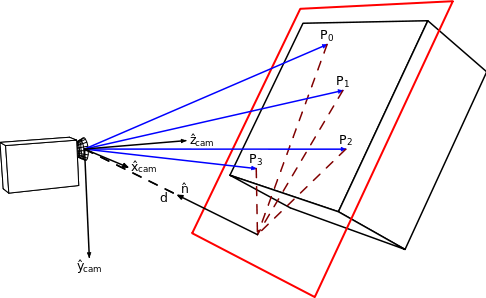

Примеры теорем о проективной плоскости (красиво, но не важно для дальнейшего повествования)
$\mathrm{P}^2$ также можно представить как множество лучей (хотя точнее будет сказать прямых), вложенных в $R^3$ и проходящих через начало координат. Лучи, пересекающие плоскость $z = 1$, соответствуют конечным точкам $\mathrm{P}^2$, а лучи в плоскости $z = 0$ — идеальным.

Гомография $H$ (проективное преобразование) — это преобразование $\mathrm{P}^2 \to \mathrm{P}^2$ которое прямые переводит в прямые. Для нас важно, что гомография задаётся умножением однородных координат на обратимую матрицу $H_{3 \times 3}$. Обратите внимание, что гомография $wH$ задаёт одно и то же преобразование для всех ненулевых множителей $w$.

Давайте вспомним, как работает модель пинхол камеры. Она задаёт то, как 3D-точка $(x, y, z)$ проецируется в точку $(u, v)$ на плоскости изображения:
$$u = f_x\frac{x}{z} + c_x, v = f_y\frac{y}{z} + c_y$$

В эту же точку $(u, v)$ проецируются все точки на луче$ w (x, y, z), w \ne 0$. То есть модель камеры сопоставляет 2D-точку в плоскости изображения лучу в 3D пространстве.

В  $\mathrm{P}^2$ мы сопоставляем точке $(x, y, 1)$ в плоскости $z = 1$ луч (прямую) $w (x, y, 1), w \ne 0$. То есть отождествление точки на плоскости с лучём в 3D уже подразумевается и само по себе "проецирование" уже произошло. Для того, чтобы соответствовать модели пинхол камеры, осталось сделать растяжение и смещение плоскости. Это можно сделать следующей гомографией:


$$H_p = \begin{pmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{pmatrix}$$


Давайте проверим. Пусть у нас задана точка $(x, y, z)$. "Спроецируем" её на плоскость изображения с помощью гомографии $H_p$.
$$H_p(x, y, z)^T = (f_xx + c_xz, f_yy + c_yz, z) \sim (f_x\frac{x}{z} + c_x, f_y\frac{y}{z} + c_y, 1)$$
То же самое, что предполагается моделью камеры.

Кроме операции проецирования нам интересна операция поворота в 3D. Поворот в 3D задаётся обратимой матрицей $R_{3\times3}$. Эта же матрица является матрицей гомографии в $\mathrm{P}^2$ и работает точно так же. Только теперь уже на элементах $\mathrm{P}^2$. То есть вращает не точки в $R^3$, а лучи (прямые).

**Аффинная гомография**
Когда область изображения, в которой вычисляется гомография, мала или изображение было получено с большим фокусным расстоянием, аффинная гомография является более подходящей моделью смещения изображения. Аффинная гомография - это особый тип общей гомографии, последняя строка которой зафиксирована на 

Источники:
https://habr.com/ru/articles/708986/

### 2. Делаем свои милые фотокарточки и превращаем их в плоскую панормау

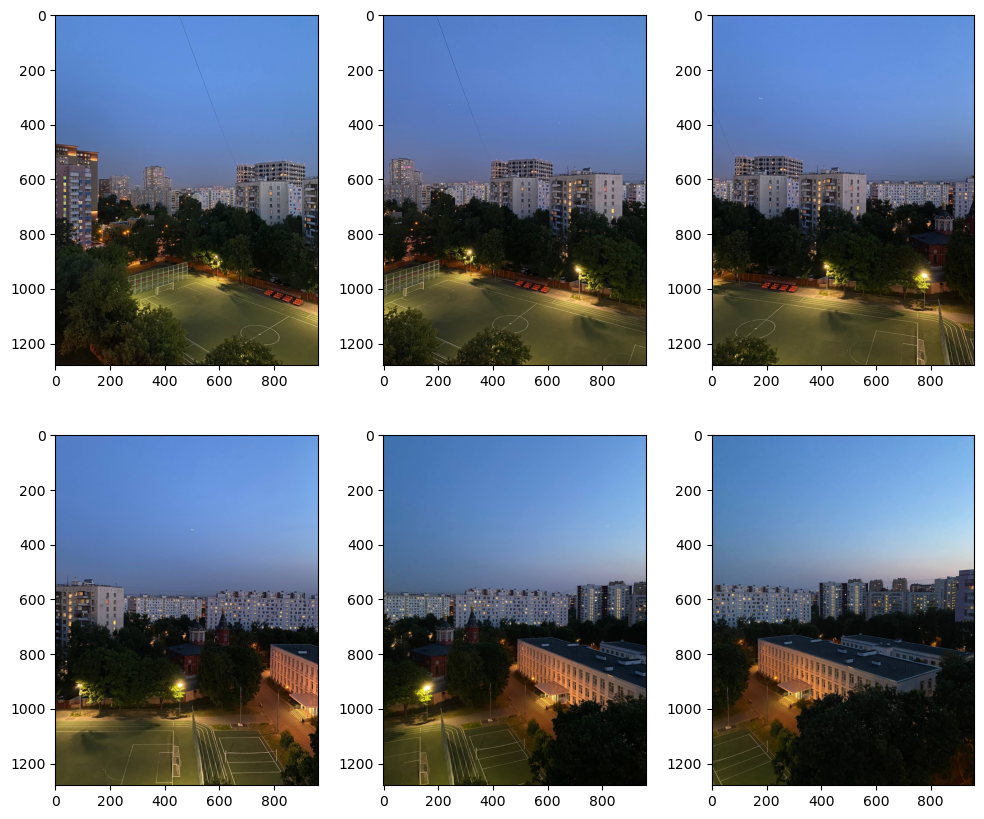

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
for i, j in enumerate(['images/1.jpg', 'images/2.jpg', 'images/3.jpg', 
                               'images/4.jpg', 'images/5.jpg', 'images/6.jpg']):
    img = cv2.imread(j)
    axs.flat[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
plt.show()

In [23]:
def make_pano(image_paths: list) -> None:
    
    # Инициализация объекта SIFT (определение ключевых точек)
    sift = cv2.xfeatures2d.SIFT_create()
    
    # Нахождение ключевых точек и дескрипторов на изображениях
    data = {}
    for path in image_paths:
        img = cv2.imread(path)
        kp, des = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), None)
        data.update({path: [kp, des, img]})
    
    
#     start_img = list(data.items())[0]
    start_img = dict(list(data.items())[:len(data)//len(data)])  # берем первый item дикта data
    data.pop(next(iter(data)))  # удаляем первый элемент
    
    for pos, item in enumerate(data.items()):  # дальше будем итерировать без первого по очереди (брать 2, 3 и тд) и приклеивать к тому что сделали до этого
        start_img.update({item[0]:item[1]})  # теперь start_image это словарь {path: [kp, des, img]} из данных по первым двум фото
        # в след итерациях (после первой) start_image будет словарем  из пано из предыдйщих двух фото + следуюшее фото
        
        # Нахождение соответствий между дескрипторами на изображениях
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
        cur_des = list(map(lambda val: val[1], start_img.values()))
        matches = matcher.knnMatch(cur_des[0], cur_des[1], k=2)
        
        # Фильтрация соответствий с помощью метрики Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        # Нахождение матрицы гомографии
        cur_kps = list(map(lambda val: val[0], start_img.values()))
        src_pts = np.float32([cur_kps[0][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([cur_kps[1][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        
        # Преобразование изображений
        cur_imgs = list(map(lambda val: val[2], start_img.values()))
        panorama = cv2.warpPerspective(cur_imgs[0], H, (cur_imgs[0].shape[1] + cur_imgs[1].shape[1], cur_imgs[1].shape[0]))
        panorama[0:cur_imgs[1].shape[0], 0:cur_imgs[1].shape[1]] = cur_imgs[1]

        kp, des = sift.detectAndCompute(cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY), None)
        start_img = {'none': [kp, des, panorama]}
        
    return panorama

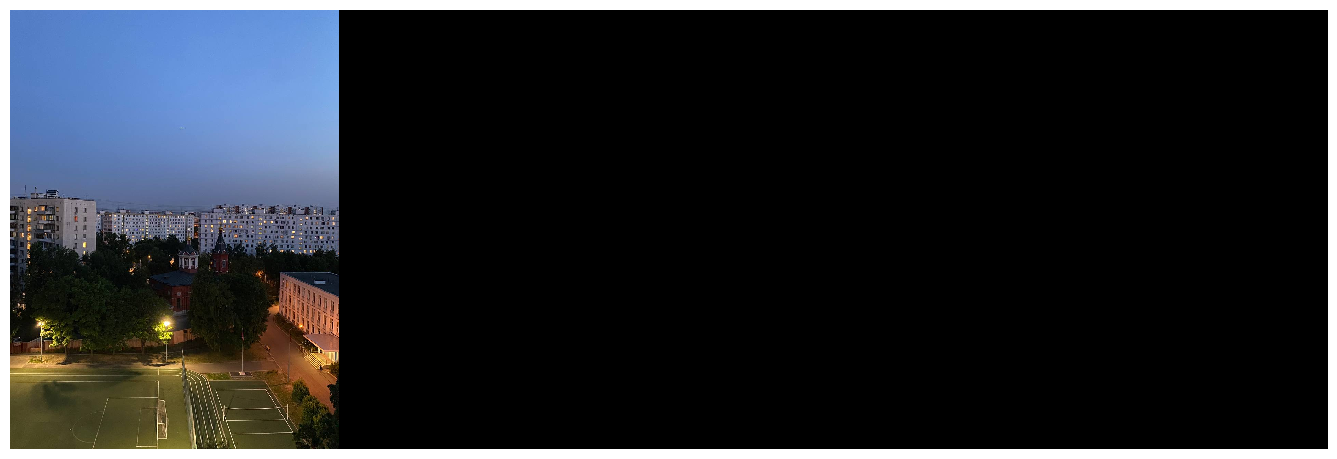

In [24]:
# Отображение результата
panorama = make_pano([
                'images/1.jpg', 
                'images/2.jpg', 
                'images/3.jpg', 
                'images/4.jpg', 
#                 'images/5.jpg', 
#                 'images/6.jpg'
                     ])

plt.figure(figsize = (17,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB), interpolation='nearest')
plt.show()
# cv2.imshow('Panorama', panorama)
# cv2.waitKey()

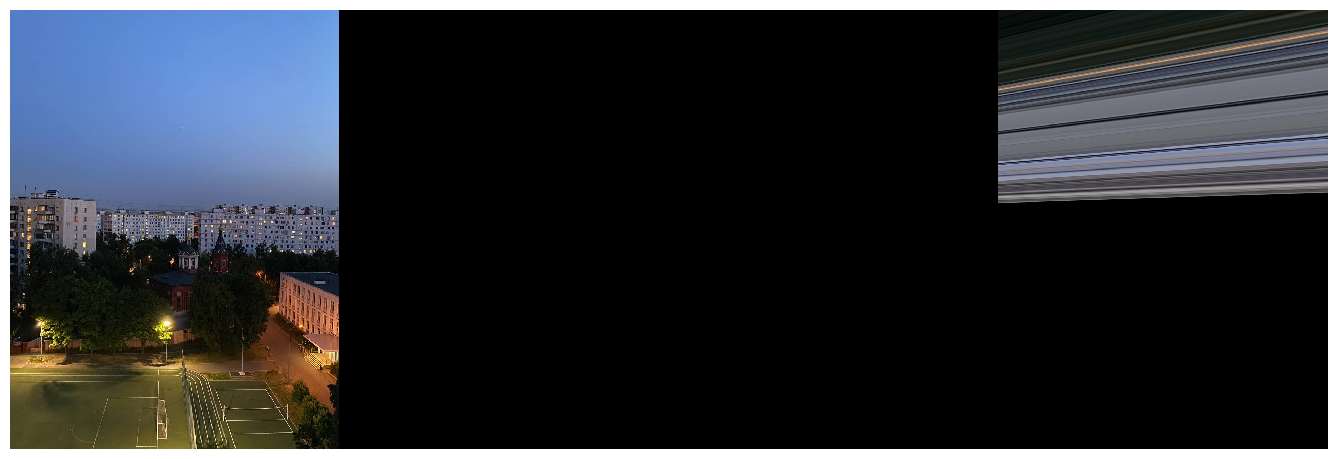

In [25]:
def get_h(img1, img2):
    # Преобразование изображений в оттенки серого
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Инициализация объекта SIFT (определение ключевых точек)
    sift = cv2.xfeatures2d.SIFT_create()

    # Нахождение ключевых точек и дескрипторов на обоих изображениях
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Нахождение соответствий между дескрипторами на двух изображениях
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    matches = matcher.knnMatch(des1, des2, k=2)

    # Фильтрация соответствий с помощью метрики Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Нахождение матрицы гомографии
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H

def append(img1, img2):
    H = get_h(img1, img2)
    # Преобразование изображений
    panorama = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img2.shape[0]))
    panorama[0:img2.shape[0], 0:img2.shape[1]] = img2
    return panorama

# Загрузка изображений
img1 = cv2.imread('images/1.jpg')
img2 = cv2.imread('images/2.jpg')
img3 = cv2.imread('images/3.jpg')
img4 = cv2.imread('images/4.jpg')

panorama = append(img2, img3)
panorama = append(panorama, img4)
panorama = append(img1, panorama)

# cv2.imshow('Panorama', panorama)
plt.figure(figsize = (17,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB), interpolation='nearest')
plt.show()

In [21]:
# img1 = cv2.imread('images/1.jpg')
# img2 = cv2.imread('images/3.jpg')

# # Преобразование изображений в оттенки серого
# gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# # Инициализация объекта SIFT (определение ключевых точек)
# sift = cv2.xfeatures2d.SIFT_create()

# # Нахождение ключевых точек и дескрипторов на обоих изображениях
# kp1, des1 = sift.detectAndCompute(gray1, None)
# kp2, des2 = sift.detectAndCompute(gray2, None)

# # Нахождение соответствий между дескрипторами на двух изображениях
# matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
# # matcher = cv2.BFMatcher()
# matches = matcher.knnMatch(des1, des2, k=2)

# # Фильтрация соответствий с помощью метрики Lowe's ratio test
# good_matches = []
# for m, n in matches:
#     if m.distance < 0.65 * n.distance:
#         good_matches.append(m)

# # Нахождение матрицы гомографии
# src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# # Преобразование изображений
# panorama = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img2.shape[0]))
# panorama[0:img2.shape[0], 0:img2.shape[1]] = img2

# # Отображение результата
# # cv2.imshow('Panorama', panorama)
# # cv2.waitKey()
# # cv2.destroyAllWindows()

# # cv2.imwrite('output.jpg',dst)
# plt.imshow(panorama)
# plt.show()

In [107]:
d = {'a': [1, 2], 'b': [3, 4], 'c': [5, 6]}

In [103]:
list(map(lambda val: val[0], d.values()))

[3, 5, 7]

In [83]:
list(d.items())[0]

('a', [1, 2])

In [84]:
len(d)

3

In [85]:
dict(list(d.items())[:len(d)//2])

{'a': [1, 2]}

In [86]:
dict(list(d.items())[:len(d)//len(d)])

{'a': [1, 2]}

In [87]:
for i, j in enumerate(d.items()):
    print(i)

0
1
2


In [88]:
start_img = dict(list(d.items())[:len(d)//len(d)])

In [77]:
list(start_img.keys())

['a']

In [80]:
d

{'b': [3, 4], 'c': [5, 6]}

In [102]:
d = {'a': [1, 2], 'b': [3, 4], 'c': [5, 6], 'd': [7, 8]}
start_img = dict(list(d.items())[:len(d)//len(d)]) # берем самый левый элемент
d.pop(next(iter(d)))  # удаляем левый жлемет
for i, j in enumerate(d.items()): 
    start_img.update({j[0]:j[1]})
    print(start_img)
    start_img = {'f': 'f'}

{'a': [1, 2], 'b': [3, 4]}
{'f': 'f', 'c': [5, 6]}
{'f': 'f', 'd': [7, 8]}


### Триангуляция